In [1]:
"""
Based on: https://gist.github.com/jkarimi91/d393688c4d4cdb9251e3f939f138876e

This script will demonstrate how to use a pretrained model, in PyTorch, 
to make predictions. Specifically, we will be using VGG16 with a cat 
image.
References used to make this script:
PyTorch pretrained models doc:
    http://pytorch.org/docs/master/torchvision/models.html
PyTorch image transforms example:
    http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
Example code:
    http://blog.outcome.io/pytorch-quick-start-classifying-an-image/    
"""

import io

from PIL import Image
import requests
import torch
import torch.nn.functional as F

from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

%matplotlib inline

In [2]:
np.random.seed(42)
torch.manual_seed(42)

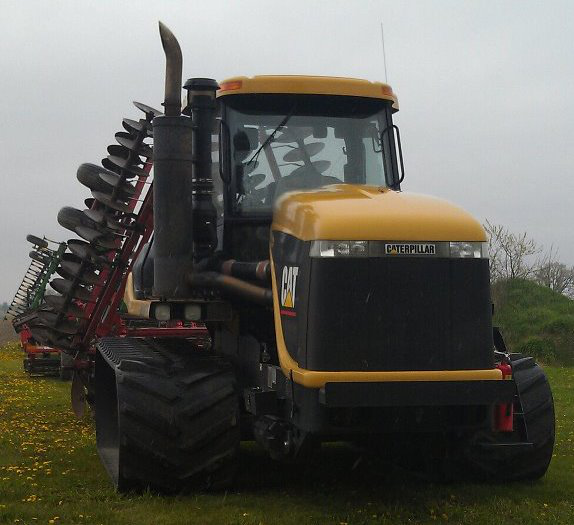

In [3]:
# Random cat img taken from Google
IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/c3/Caterpillar_rubber_tracked_tractor.jpg'
# Class labels used when training VGG as json, courtesy of the 'Example code' link above.
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

# Let's get our class labels.
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

# Let's get the cat img.
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))  # Read bytes and store as an img.

# Let's take a look at this cat!
img

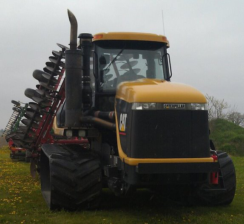

In [4]:
# Now that we have an img, we need to preprocess it.
# We need to:
#       * resize the img, it is pretty big (~1200x1200px).
#       * normalize it, as noted in the PyTorch pretrained models doc,
#         with, mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
#       * convert it to a PyTorch Tensor.
#
# We can do all this preprocessing using a transform pipeline.
min_img_size = 224  # The min size, as noted in the PyTorch pretrained models doc, is 224 px.

pre_transform = transforms.Compose([transforms.Resize(min_img_size),
                                         transforms.RandomRotation(0.001)])
img = pre_transform(img)
img

In [5]:
transform_pipeline = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
img = transform_pipeline(img)

# PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
# Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
img = img.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims. 

In [6]:
K=5
# Now let's load our model and get a prediciton!
vgg = models.vgg16(pretrained=True)  # This may take a few minutes.
prediction = vgg(img)  # Returns a Tensor of shape (batch, num class labels)
probs = F.softmax(prediction,dim=1)
print("Prediction size: ",prediction.size())
top_probs, top_labels = torch.topk(probs, k=K, dim=1)
print(top_labels)
for i in range(K):
    print('Prob: ',top_probs[0][i].item(),', label: ',labels[top_labels[0][i].item()])
prediction = prediction.data.numpy().argmax()  # Our prediction will be the index of the class label with the largest value.
print(labels[prediction])  # Converts the index to a string using our labels dict

Prediction size:  torch.Size([1, 1000])
tensor([[866, 595, 730, 856, 803]])
Prob:  0.6865396499633789 , label:  tractor
Prob:  0.23580947518348694 , label:  harvester, reaper
Prob:  0.06218535080552101 , label:  plow, plough
Prob:  0.008540197275578976 , label:  thresher, thrasher, threshing machine
Prob:  0.0041864472441375256 , label:  snowplow, snowplough
tractor
